In [50]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json
import matplotlib.image as mpimg

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [51]:
!video-toimg output_1.avi

{'duration': None, 'in_files': ['output_1.avi'], 'per': 1, 'start': 0}
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 46.38it/s]


In [52]:
DIRNAME = "output_1"
IMG_SIZE = [448, 448]

# Using effcientdet lite2-detector¶

In [53]:
# Choose threshold carefully: larger the threshold => more coarse/ fewer boxes
def get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.2):
    image = np.array(img)
    objects = 0

    for i in range(num_detections):
        if scores[i] >= score_threshold:
            box = boxes[i]
            y_min, x_min, y_max, x_max = box

            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            objects += 1

    return image, objects

In [54]:
test_images = []
test_images_size_tups = []

for file in os.listdir(DIRNAME):
    img = cv2.imread(f"{DIRNAME}/{file}")
    test_images_size_tups.append(img.shape)

    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    test_images.append(img)

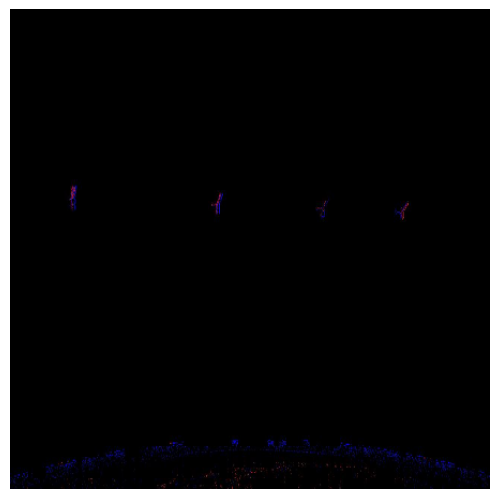

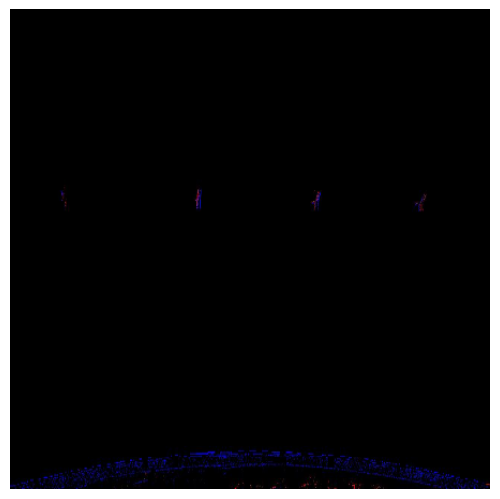

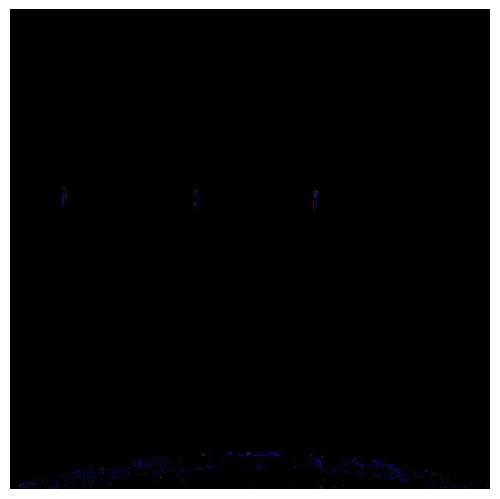

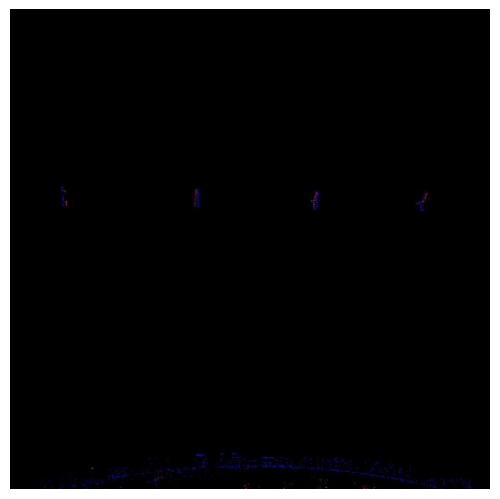

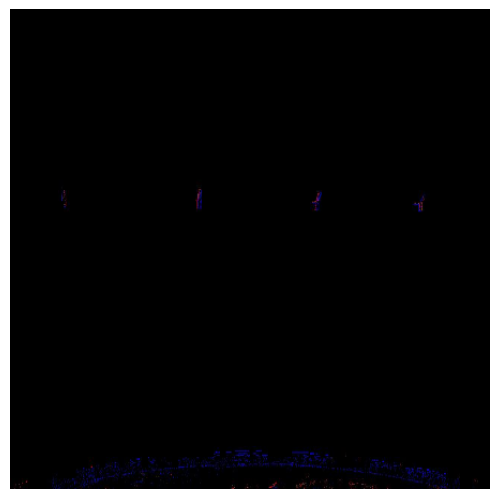

In [55]:
test_images_size_tups[:5], test_images[0].shape, test_images[0].max()

for img in test_images[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

In [56]:
effdet2_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite2-detection/versions/1")

Image index: 34
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 3


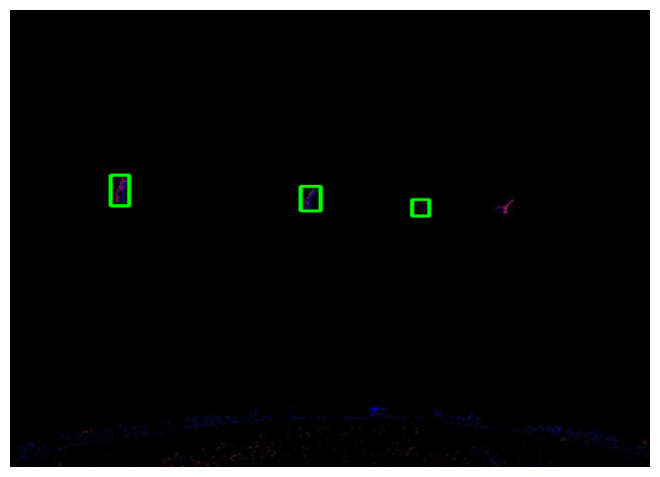

<Figure size 640x480 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize


# index = random.randint(0, len(test_images) - 1)
index = 34
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

boxes, scores, classes, num_detections = effdet2_model(image_np)

image_np = image_np[0]

print("Image shape:", image_np.shape)
print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
print()

img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

# Reshape the image to the desired dimensions
# Specify the new dimensions
new_width = 700
new_height = 500
img = resize(img, (new_height, new_width))


print("No. of objects:", objects)
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

# Create a directory to save the plots if it doesn't exist
output_folder = "results/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

plt.savefig(output_folder + str(index) + '_effdet2_result.png')


Image index: 0
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 4
Image index: 1
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 3
Image index: 2
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 3
Image index: 3
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 4
Image index: 4
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 4
Image index: 5
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 4
Image index: 6
Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (

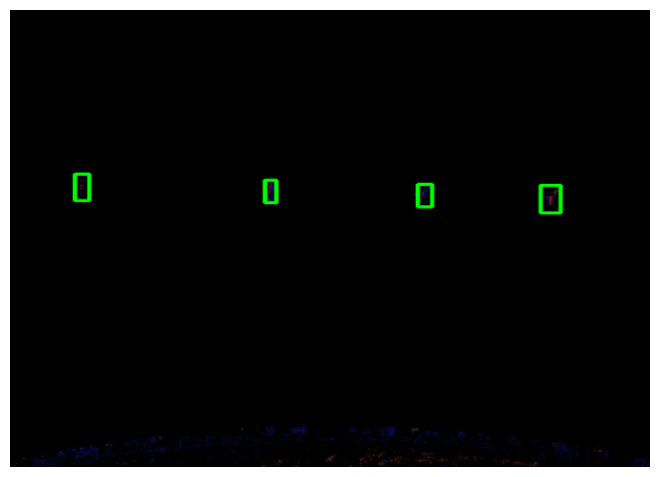

In [58]:
for index in range(len(test_images) - 1):

    # index = random.randint(0, len(test_images) - 1)
    # index = 98
    print("Image index:", index)

    sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
    sample_image_t = tf.expand_dims(sample_image_t, axis=0)
    image_np = sample_image_t.numpy()

    boxes, scores, classes, num_detections = effdet2_model(image_np)

    image_np = image_np[0]

    print("Image shape:", image_np.shape)
    print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
    print()

    img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

    # Reshape the image to the desired dimensions
    # Specify the new dimensions
    new_width = 700
    new_height = 500
    img = resize(img, (new_height, new_width))
    

    print("No. of objects:", objects)
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # plt.show()
    

    # Create a directory to save the plots if it doesn't exist
    output_folder = "results/"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.savefig(output_folder + str(index) + '_effdet2_result.png')


In [59]:
# Create Video from results

!video-fromimg --input-files "results/*.png" --fps 5 Eventcamera_detection.mp4

{'fps': 5,
 'input_files': 'results/*.png',
 'nframes': None,
 'out_file': 'Eventcamera_detection.mp4'}
Eventcamera_detection.mp4: 100%|████████████████| 59/59 [00:01<00:00, 43.66it/s]


# Using effcientdet lite3-detector¶

In [67]:
effdet3_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite3-detection/versions/1")

In [61]:
# index = random.randint(0, len(test_images) - 1)
# # index = 98
# print("Image index:", index)

# sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
# sample_image_t = tf.expand_dims(sample_image_t, axis=0)
# image_np = sample_image_t.numpy()

# boxes, scores, classes, num_detections = effdet3_model(image_np)

# image_np = image_np[0]

# print("Image shape:", image_np.shape)
# print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
# print()

# img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

# print("No. of objects:", objects)
# plt.imshow(img)

# plt.savefig("effdet3_results/" + str(index) + '_effdet3_result.png')

In [62]:
# for index in range(len(test_images) - 1):

#     # index = random.randint(0, len(test_images) - 1)
#     # index = 98
#     print("Image index:", index)

#     sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
#     sample_image_t = tf.expand_dims(sample_image_t, axis=0)
#     image_np = sample_image_t.numpy()

#     boxes, scores, classes, num_detections = effdet3_model(image_np)

#     image_np = image_np[0]

#     print("Image shape:", image_np.shape)
#     print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
#     print()

#     img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

#     print("No. of objects:", objects)
#     plt.imshow(img)
#     plt.savefig("effdet3_results/" + str(index) + '_effdet3_result.png')

# Using faster-rcnn-inception-resnet-v2

RESNET_IMG_SIZE = [640, 640]

In [63]:
RESNET_IMG_SIZE = [640, 640]

In [64]:
resnet_model = hub.KerasLayer("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [65]:
resnet_test_images = []

for file in os.listdir(DIRNAME):
    img = cv2.imread(f"{DIRNAME}/{file}")
    img = cv2.resize(img, RESNET_IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.constant(img, dtype=tf.uint8)

    resnet_test_images.append(img)

In [66]:
# index = random.randint(0, len(resnet_test_images) - 1)
# # index = 98
# print("Image index:", index)

# sample_image_t = tf.constant(resnet_test_images[index], dtype=tf.uint8)
# sample_image_t = tf.expand_dims(sample_image_t, axis=0)
# image_np = sample_image_t.numpy()

# resnet_output_dict = resnet_model(image_np)

# image_np = image_np[0]

# resnet_boxes = resnet_output_dict.get("detection_boxes")[0] * RESNET_IMG_SIZE[0]
# resnet_scores = resnet_output_dict.get("detection_scores")[0]
# resnet_num_detections = int(resnet_output_dict.get("num_detections")[0])

# print("Image shape:", image_np.shape)
# print("Model Result Shapes:", resnet_boxes.shape, resnet_scores.shape, resnet_num_detections)
# print()

# img, objects = get_annotated_img_objects(image_np, resnet_boxes, resnet_scores, resnet_num_detections, 0.1)

# print("No. of objects:", objects)
# plt.imshow(img)